# My Solution #

In [30]:
# Packages
import pandas as pd
import os
import warnings

import sklearn as skl
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore",category=OptimizeWarning)


# Exploratory Analysis #

In [31]:
# Import the data
# NOTE: Ensure that the data file is in the same directory as the notebook
df = pd.read_excel("Data_Scientist_Interview-Data_File.xlsx", sheet_name="Data")

This dataset contains three columns:  

- **Keys**: a numerical identifier  
- **x**: a continuous float variable  
- **y**: a continuous float variable  

The **Keys** column can be interpreted as representing ad slots on a page, marketing channels, or manufactured products.  
The **x** variable can represent bid price, marketing spend, or the number of products made.  
The **y** variable can represent the number of bids, revenue, or the cost per product.  


## Keys and Blocks ##

While inspecting the data, I noted that the data consist of a sequence partitioned into blocks, where each block is internally ordered, but the overall sequence is not globally ordered (think groups of monotonically increasing sequences!).

As a result, the data within each key was partitioned into "blocks" which were then numbered. See example below:
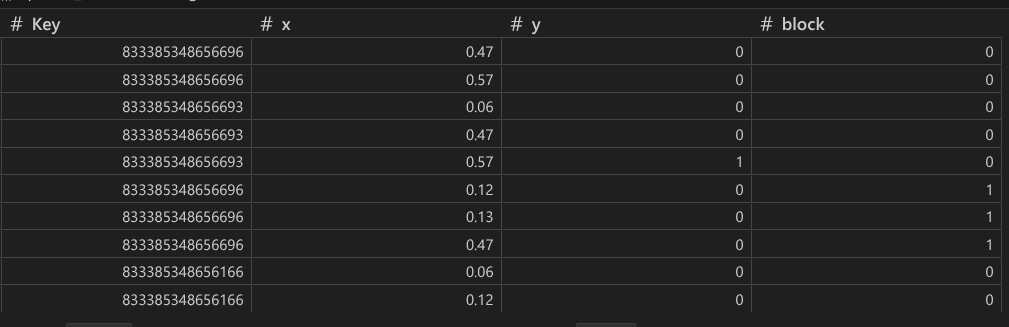

We can assume that each block corresponds to a subset of data such as time period etc.




In [32]:
# Break each of the keys into blocks.  
def assign_block_numbers(group):
    # Identify where x decreases
    seq = (group["x"].diff() < 0).cumsum()
    group = group.copy()
    group["block"] = seq
    return group

df_bl = df.groupby("Key", group_keys=False).apply(assign_block_numbers)

/tmp/ipykernel_52174/3367452588.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bl = df.groupby("Key", group_keys=False).apply(assign_block_numbers)


In [33]:
# Summary function for the dataset

def summarize_dataset(df):
    summary_bl = (
        df.groupby(["Key", "block"])
          .agg(
              n_obs=("x", "count"),
              x_mean=("x", "mean"),
              x_std=("x", "std"),
              x_min=("x", "min"),
              x_max=("x", "max"),
              y_mean=("y", "mean"),
              y_std=("y", "std"),
              y_min=("y", "min"),
              y_max=("y", "max")
          )
          .reset_index()
    )

    # global stats
    dataset_summary = pd.DataFrame({
        "Statistic": [
            "Total observations",
            "Unique Keys",
            "Total blocks",
            "Average obs per block",
            "Median obs per block",
            "Min block size",
            "Max block size",
            "Std of block sizes",
            "Avg blocks per Key",
            "Std of blocks per Key",
            "Min x value",
            "Min y value"
        ],
        "Value": [
            len(df),
            df["Key"].nunique(),
            summary_bl.shape[0],
            summary_bl["n_obs"].mean(),
            summary_bl["n_obs"].median(),
            summary_bl["n_obs"].min(),
            summary_bl["n_obs"].max(),
            summary_bl["n_obs"].std(),
            df.groupby("Key")["block"].nunique().mean(),
            df.groupby("Key")["block"].nunique().std(),
            summary_bl['x_min'].min(),
            summary_bl['y_min'].min()
        ]
    })

    return dataset_summary, summary_bl

In [34]:
# Summary Statistics for the dataset
dataset_summary, summary_bl = summarize_dataset(df_bl)

print("### Dataset Overview ###")
display(dataset_summary)

print("### Block-Level Summary ###")
display(summary_bl.head(10))

### Dataset Overview ###


,Statistic,Value
0,Total observations,161681.000000
1,Unique Keys,173.000000
2,Total blocks,1012.000000
3,Average obs per block,159.763834
4,Median obs per block,96.000000
5,Min block size,1.000000
6,Max block size,2102.000000
7,Std of block sizes,210.764236
8,Avg blocks per Key,5.849711
9,Std of blocks per Key,7.563719


### Block-Level Summary ###


,Key,block,n_obs,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max
0,82353292333796,0,252,1.555397,1.430661,0.01,13.52,621.694444,3445.733291,0,46531
1,82353292333796,1,485,7.317876,7.216799,1.66,81.64,3.690722,5.503119,0,47
2,82353292333796,2,100,11.276000,10.354252,3.21,74.95,0.000000,0.000000,0,0
3,96272529898556,0,258,2.146667,1.466208,0.47,10.39,113.585271,208.578295,0,1820
4,96272529898556,1,682,11.029106,16.188167,0.48,199.84,3.237537,6.513233,0,74
5,96272529898556,2,98,23.478776,35.205359,3.57,240.00,0.000000,0.000000,0,0
6,96273983898538,0,175,1.596743,0.779577,0.59,4.92,255.788571,1297.772449,0,16221
7,96273983898538,1,400,6.681050,7.432921,1.69,90.92,3.020000,6.061473,0,97
8,96273983898538,2,86,11.681860,13.040158,3.23,100.00,0.000000,0.000000,0,0
9,96273983898544,0,311,2.587685,2.289240,0.59,23.68,205.546624,904.227571,0,14832


In [35]:
# There are no nulls in the dataset
print(f' Number of Null values:\n {df_bl.isnull().sum()}')

 Number of Null values:
 Key      0
x        0
y        0
block    0
dtype: int64


classify the graphs into categories with example: linear, concave and some randoms

For outliers, we assume that each (Key, block) pair must have **at least 10 observations** to ensure there is enough data to reliably fit the chosen curve.  
This threshold is chosen because our models have multiple parameters, and having fewer than 10 points can lead to unstable fits or overfitting.  
Using this criterion, we removed **94 groups** from the dataset.

In [36]:
n_outliers = (summary_bl["n_obs"] < 10).sum()

print("Number of key/block pairs with fewer than 10 observations:", n_outliers)

Number of key/block pairs with fewer than 10 observations: 94


In [37]:

valid_pairs = summary_bl.loc[summary_bl["n_obs"] >= 10, ["Key", "block"]]

df_bl_filtered = df_bl.merge(valid_pairs, on=["Key", "block"], how="inner")

original_groups = summary_bl.shape[0]
kept_groups = valid_pairs.shape[0]
removed_groups = original_groups - kept_groups

print(f"Original groups: {original_groups}")
print(f"Kept groups (>=10 obs): {kept_groups}")
print(f"Removed groups (<10 obs): {removed_groups}")

Original groups: 1012
Kept groups (>=10 obs): 918
Removed groups (<10 obs): 94


From our observations, many of the curves exhibit a decaying, concave-up relationship between **x** and **y**, though not all. A few examples show bumps and concave-down behavior. For the vast majority of cases, however, the concave-up pattern dominates.  

To determine the point of diminishing return, we approach this in two steps:  
1. Fit the curve using an appropriate model.  
2. Use the geometry of the fitted model to approximate the diminishing return point based on the expected value of the marginal return.  

The performance of this process depends on how well the model fits the data.

# Fitting a Curve #

## The Power Model ##

Let $(Y, X)$ be random variables corresponding to our data, where $X$ takes values in a closed interval $[x_0, x_1]$ with $x_0 > 0$.  
Define  
$$
r(x) = \mathbb{E}[Y \mid X = x],
$$  
which represents the conditional expectation of $Y$ given $X = x$.  

From our observations, $r(x)$ for this data typically exhibits a **decaying, concave-up behavior**.  
Based on this, we make the following assumption:

**Assumption**:
*I assume that the conditional expectation function of $Y$ given $X$, denoted by $r(x)=\mathbb{E}[Y|X=x]$ can be approximated by a model of the form $r(x) \approx ax^{-b} + c$ for $a,b,c>0$.* 

**Some Remarks about our model**
Let $f(x) = ax^{-b} + c$ and note that we have the following properties:
- The first derivative $f'(x) = -abx^{-b-1}$ is always negative; 
- The second derivative $f''(x) = ab(b+1)x^{-b-2}$ is always positive, hence concave up.
- By the mean value theorem, there is a point on the interval which has the same derivative as the secant line, and by concavity it must be unique.

Let’s look at an example from our data and fit an appropriate curve to it. In the figure below, the **raw data** is shown as a blue line, the **fitted curve** as a red dotted line, along with the corresponding evaluation metrics.  

We use the following metrics to assess the fit:  

- **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE):** measure the overall error of the fitted curve.  
- **$R^2$ (Coefficient of Determination):** captures how well the fitted curve explains the underlying trend in the data.  
- **Mean Absolute Error (MAE):** evaluates fit quality while being more resilient to outliers, which is important since many examples exhibit significant oscillations.  


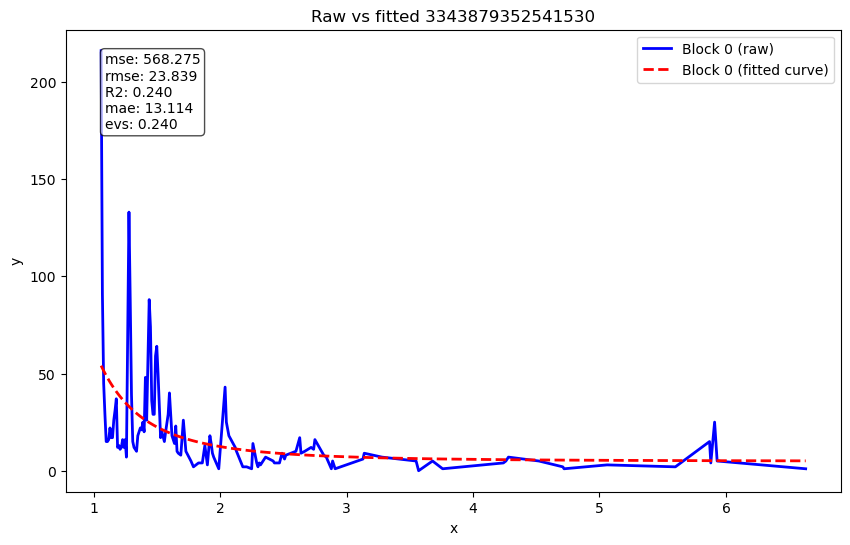

See below for more examples.


In [38]:
# Functions needed to fit our curve.


def power_fun(x,a,b,c):
    return a * x**(-b) + c

# other models we experiemented with

def log_fun(x,a,b,c): 
    return a*np.log(x + np.abs(b)) + c

def decay_exp_fun(x,a,b,c):
    return a*np.exp(-b*x) + c

def fit_curve(x_col, y_col, model = 'power',ss_req=10):
    """ Used to fit a curve to the data with respect to one of the models: 
        - negative power function
        - logarithmic function
        - negative exponential function
        
        Parameters: 
        - x_col: x-values
        - y_col: y-values
        - model: type of model, can be 'power', 'log', and 'decay_exp'
        - ss_req: the sample size requirement
        
        Returns:
        - success: if the data was able to be fitted
        - metrics: dictionary of metric values
        - fit_col: the fitted y-values
        - params: the list of params a,b,c"""

    if model == 'power':
        func = power_fun
    elif model == "log":
        func = log_fun
    elif model == 'decay_exp':
        func = decay_exp_fun
    else:
        raise ValueError('Model must be "power", "log", or "decay_exp"')
    
    if len(x_col)<ss_req:
        metrics = {'mse':None, 'rmse': None, 'R2':None, 'mae': None, 'evs':None}
        return False, metrics, None, None
    
    try: 
        params, _ = curve_fit(func,x_col,y_col)

        fit_col = func(x_col,*params)

        mse = mean_squared_error(y_col,fit_col)
        R2 = r2_score(y_true = y_col, y_pred = fit_col)
        mae = mean_absolute_error(y_col, fit_col)
        evs = explained_variance_score(y_col, fit_col)
        

        metrics = {'mse':mse, 'rmse': np.sqrt(mse), 'R2':R2, 'mae': mae, 'evs':evs}

        return True, metrics, fit_col, params
    except Exception:

        #fit failed
        metrics = {'mse':None, 'rmse': None, 'R2':None, 'mae': None, 'evs':None}
        return False, metrics, None, None

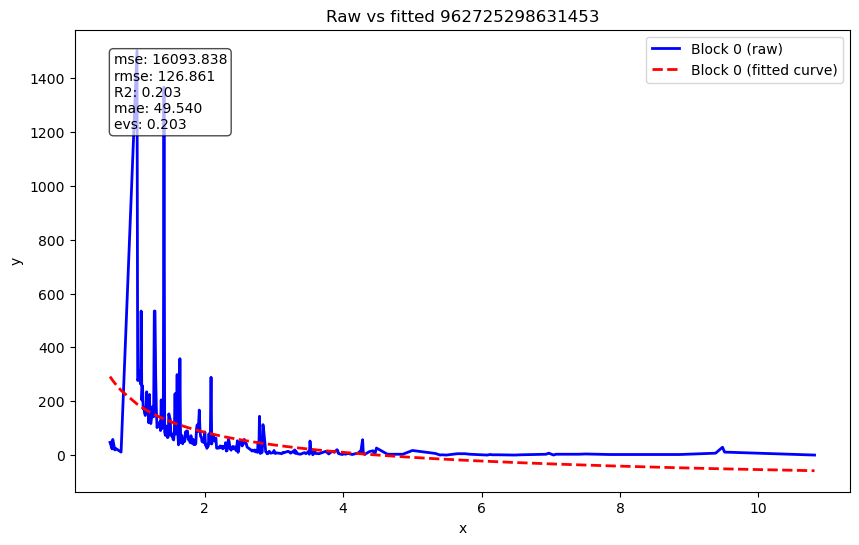

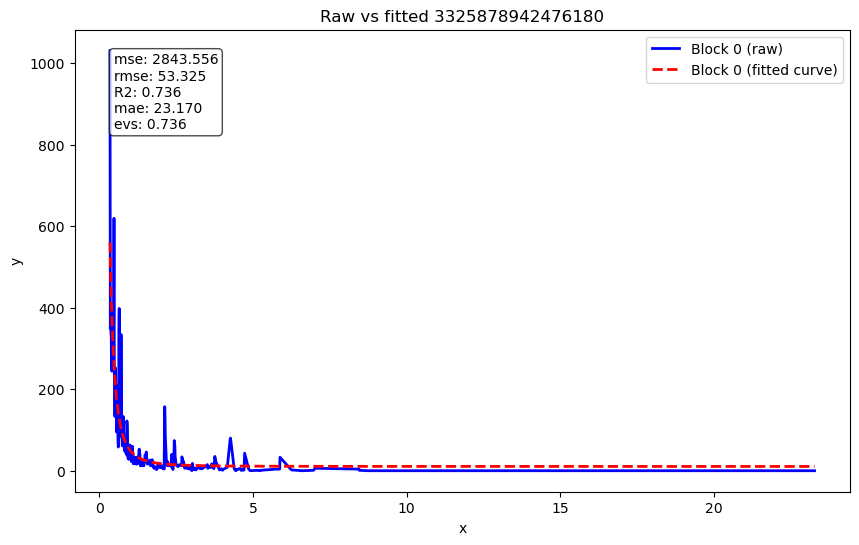

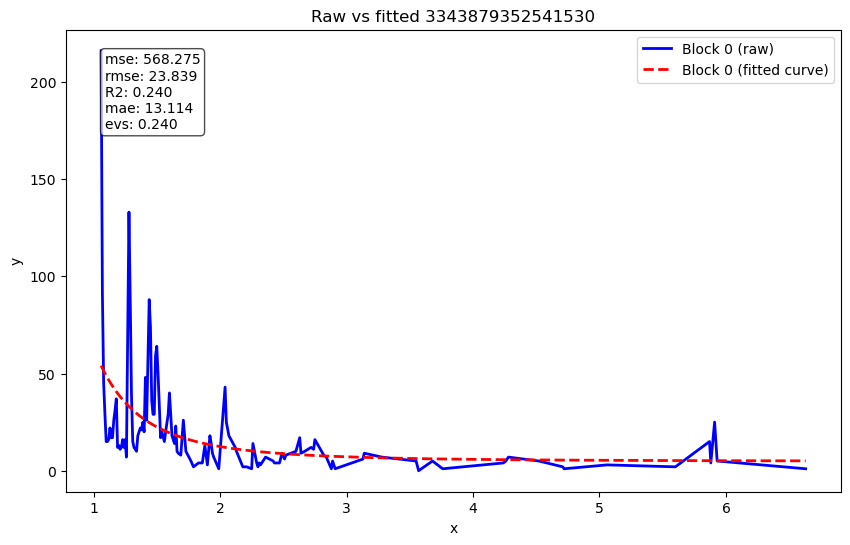

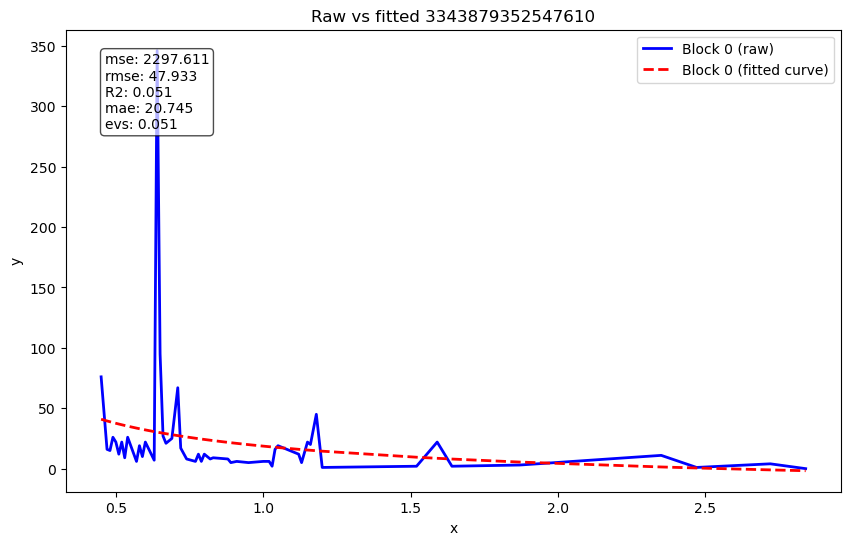

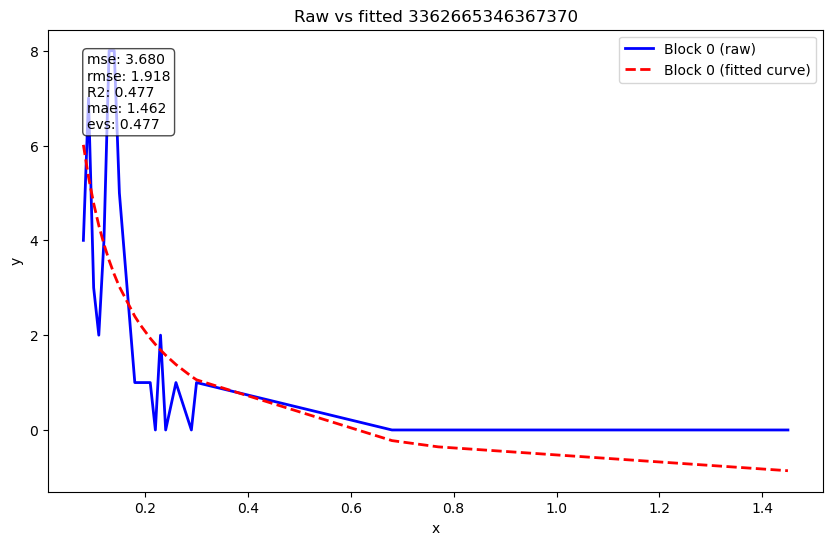

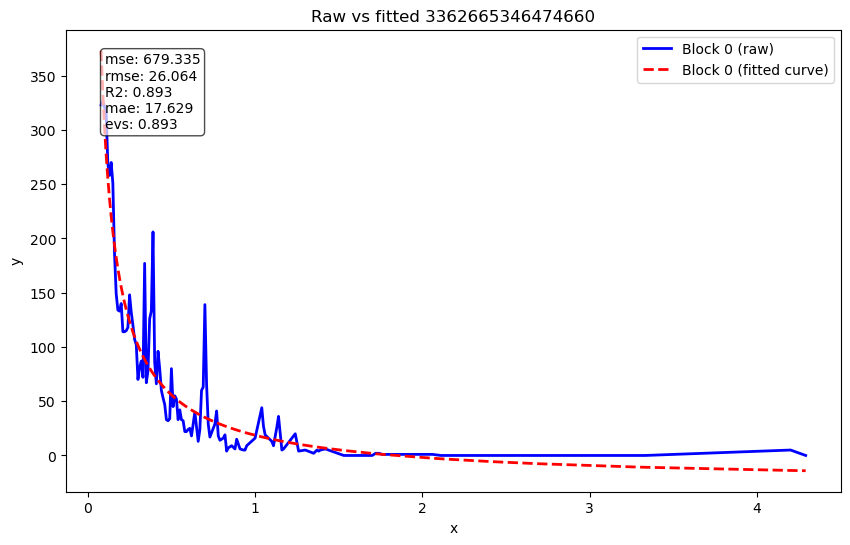

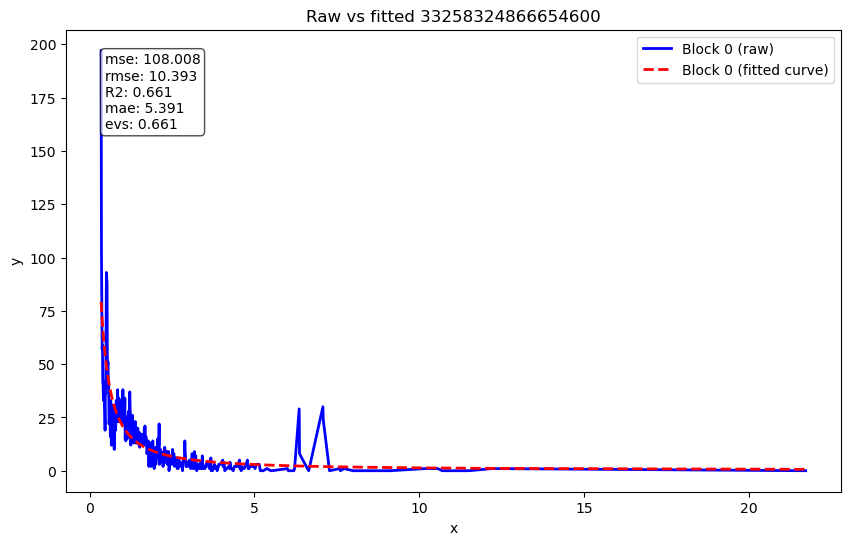

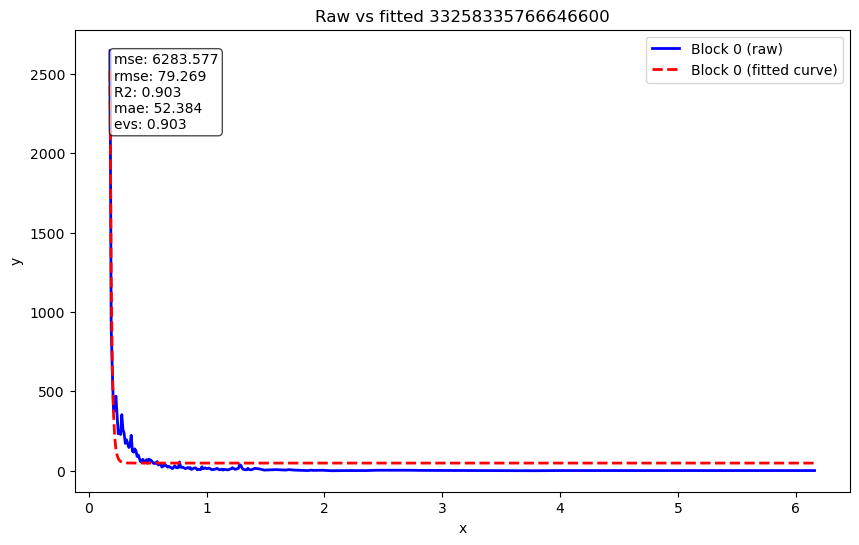

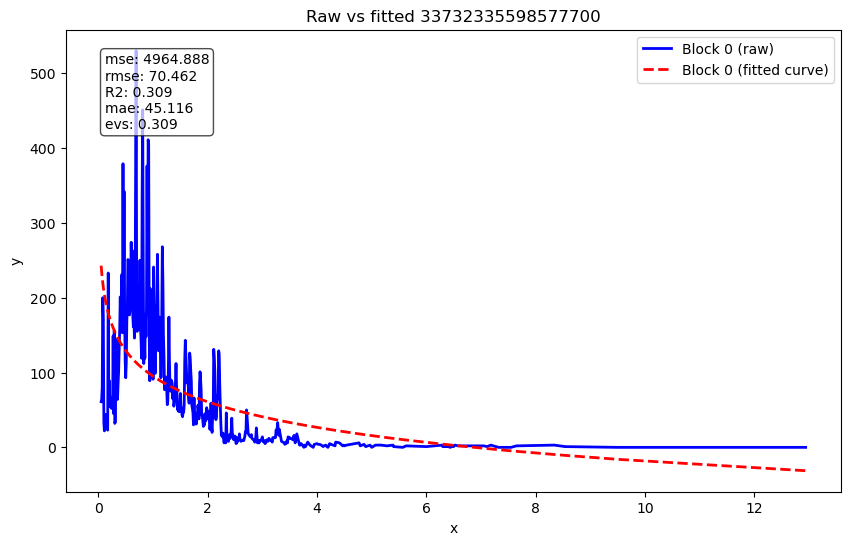

In [39]:
# Examples

examples = {
                3343879352541530: [0], 
                33258335766646600:[0],
                3325878942476180: [0],
                3362665346367370: [0],
                3325832486665400: [0],
                962725298631453: [0],
                3343879352547610: [0],
                33258324866654600: [0],
                3362665346474660:[0],
                33732335598577700:[0]

        }
df_ex = df_bl_filtered

keys = list(examples.keys())

df_subset = df_ex[df_ex['Key'].isin(keys)]


for k, group_key in df_subset.groupby("Key"):

        block_list = sorted(examples[k])

        for i, block in enumerate(block_list):
                plt.figure(figsize=(10, 6))
                group_block_sorted = group_key[group_key["block"] == block].sort_values("x")

                # compute fitted curve:
                success,metrics,fit_col,params = fit_curve(group_block_sorted["x"],group_block_sorted["y"],model='power')


                plt.plot(group_block_sorted["x"], group_block_sorted["y"],
                        color='blue', linewidth=2, label=f"Block {block} (raw)")
                plt.plot(group_block_sorted["x"], fit_col,
                        color='red', linewidth=2,linestyle='--', label=f"Block {block} (fitted curve)")
                
                metrics_text = "\n".join([f"{k}: {v:.3f}" for k, v in metrics.items()])
                plt.text(0.05,0.95,metrics_text,transform=plt.gca().transAxes,verticalalignment='top',
                         bbox=dict(boxstyle='round',facecolor='white',alpha=0.7))

                plt.xlabel("x")
                plt.ylabel("y")
                plt.title(f"Raw vs fitted {k}")
                plt.legend()
                plt.show()




The last figure above shows an example of a (Key, block) pair in the dataset that is not modeled as well as the others.  
Fitting this data would likely require a more complex model, such a function of the form $r(x)=ax^{b}e^{-cx}+d$ to help model the decay and the bump.

## Alternative Models

The other models we experimented with are the **Exponential** and **Logarithmic** models, defined as follows:

- **Exponential model:**  
$$
r(x) = a \, \exp(-b x) + c, \quad a,b > 0
$$

- **Logarithmic model:**  
$$
r(x) = a \, \log(x + b) + c, \quad b > 0
$$

The following graphs are comparisons of model fits between the power, decay exponential, and logarithmic models. As we can see, just from these examples, the power model is able to fit very well with the extreme curves of the function, while the log model fails.


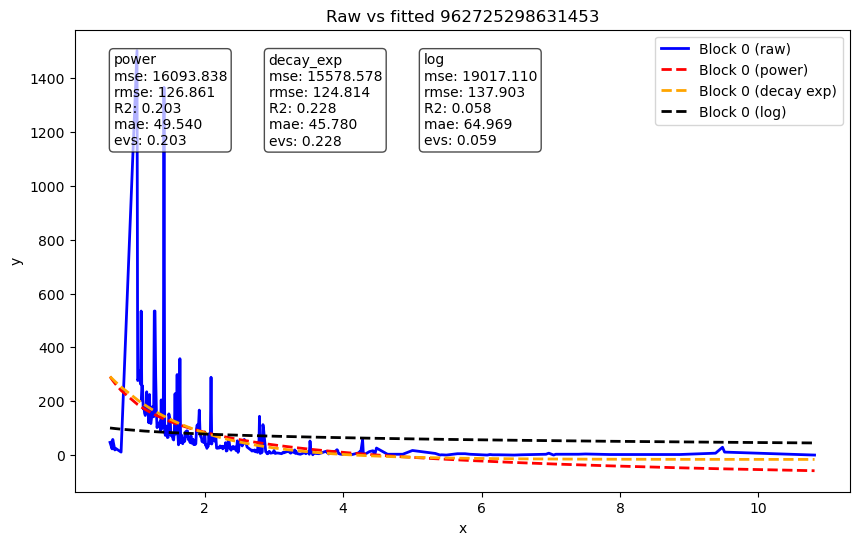

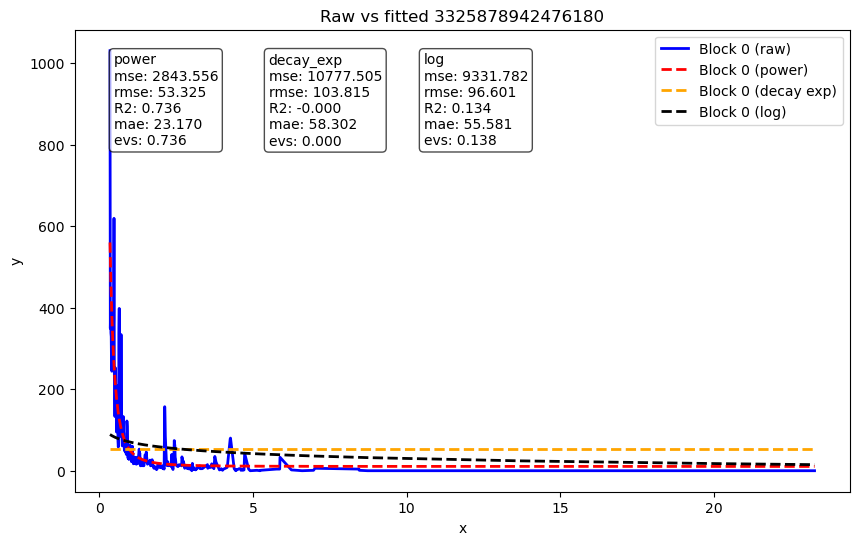

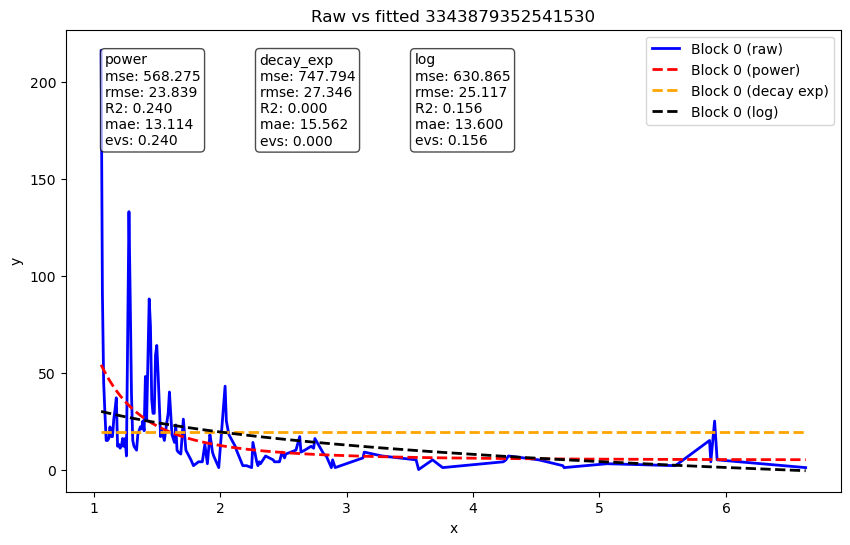

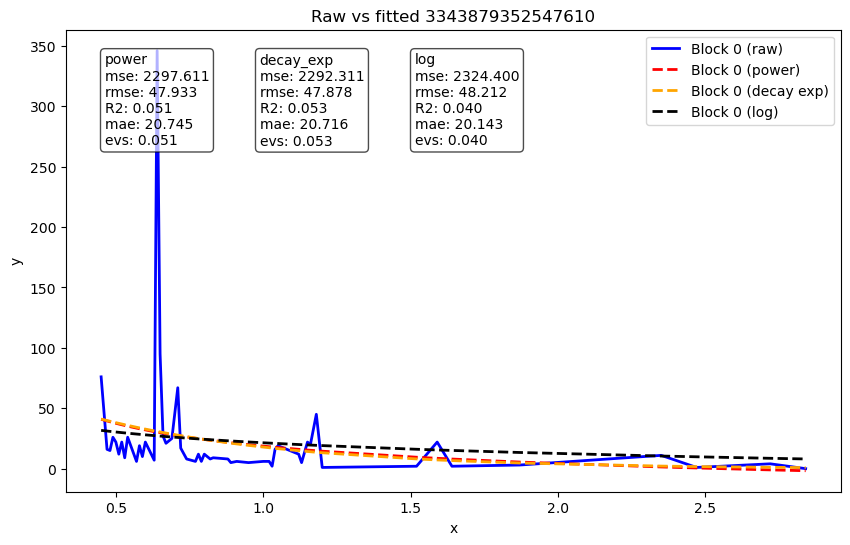

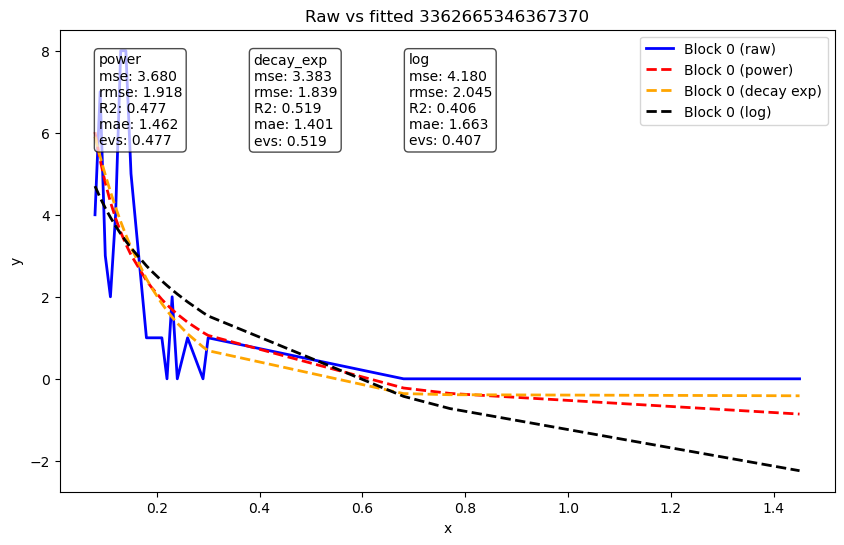

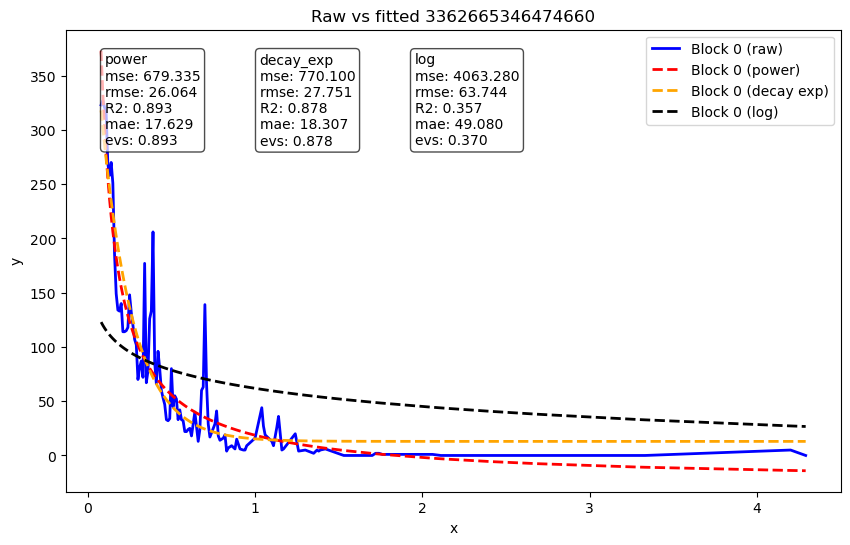

<Figure size 1000x600 with 0 Axes>

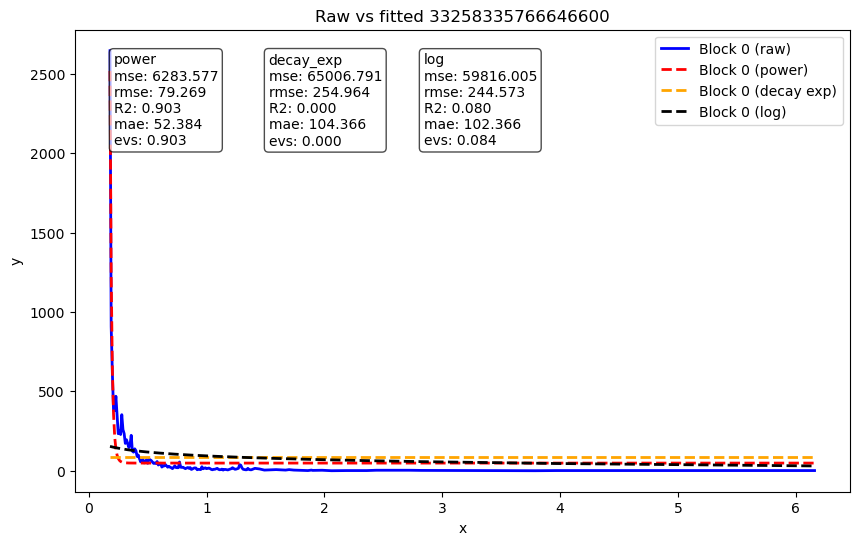

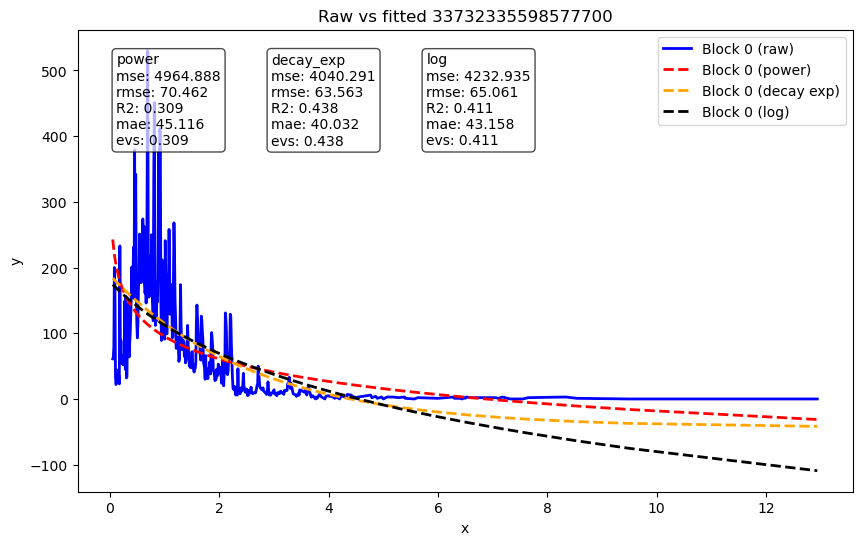

In [40]:
# Examples

examples = {
                3343879352541530: [0], 
                33258335766646600:[0],
                3325878942476180: [0],
                3362665346367370: [0],
                3325832486665400: [0],
                962725298631453: [0],
                3343879352547610: [0],
                33258324866654600: [0],
                3362665346474660:[0],
                33732335598577700:[0]

        }
df_ex = df_bl_filtered

keys = list(examples.keys())

df_subset = df_ex[df_ex['Key'].isin(keys)]


for k, group_key in df_subset.groupby("Key"):

        block_list = sorted(examples[k])

        for i, block in enumerate(block_list):
                plt.figure(figsize=(10, 6))
                group_block_sorted = group_key[group_key["block"] == block].sort_values("x")

                # compute fitted curve:
                success,metrics,fit_col,params = fit_curve(group_block_sorted["x"],group_block_sorted["y"],model='power')
                success_exp,metrics_exp,fit_col_exp,params_exp = fit_curve(group_block_sorted["x"],group_block_sorted["y"],model='decay_exp')
                success_log,metrics_log,fit_col_log,params_exp = fit_curve(group_block_sorted["x"],group_block_sorted["y"],model='log')

                if success and success_exp and success_log:
                        plt.plot(group_block_sorted["x"], group_block_sorted["y"],
                                color='blue', linewidth=2, label=f"Block {block} (raw)")
                        plt.plot(group_block_sorted["x"], fit_col,
                                color='red', linewidth=2,linestyle='--', label=f"Block {block} (power)")
                        plt.plot(group_block_sorted["x"], fit_col_exp,
                                color='orange', linewidth=2,linestyle='--', label=f"Block {block} (decay exp)")
                        plt.plot(group_block_sorted["x"], fit_col_log,
                                color='black', linewidth=2,linestyle='--', label=f"Block {block} (log)")
                        
                        metrics_text = 'power\n' + "\n".join([f"{k}: {v:.3f}" for k, v in metrics.items()])
                        plt.text(0.05,0.95,metrics_text,transform=plt.gca().transAxes,verticalalignment='top',
                                bbox=dict(boxstyle='round',facecolor='white',alpha=0.7))
                        metrics_exp_text ='decay_exp\n'+ "\n".join([f"{k}: {v:.3f}" for k, v in metrics_exp.items()])
                        plt.text(0.25,0.95,metrics_exp_text,transform=plt.gca().transAxes,verticalalignment='top',
                                bbox=dict(boxstyle='round',facecolor='white',alpha=0.7))
                        metrics_log_text ='log\n' +"\n".join([f"{k}: {v:.3f}" for k, v in metrics_log.items()])
                        plt.text(0.45,0.95,metrics_log_text,transform=plt.gca().transAxes,verticalalignment='top',
                                bbox=dict(boxstyle='round',facecolor='white',alpha=0.7))

                        plt.xlabel("x")
                        plt.ylabel("y")
                        plt.title(f"Raw vs fitted {k}")
                        plt.legend()
                        plt.show()

# Performance Metrics

In this section, we evaluate the performance of the model across all possible data blocks. For each block, we attempted to fit the model and recorded how well the fit performed. We then summarize the number of successful fits and the average performance metrics.

The metrics are defined as follows:

- **total_groups:** Total number of data groups, corresponding to all blocks across all keys.  
- **successful_fits:** Number of groups for which the model successfully found a fit. Groups that encountered optimization errors are excluded.  
- **success_rate_pct:** Percentage of total groups that were successfully fitted.  
- **avg_mse:** Average Mean Squared Error (MSE) across all successfully fitted groups.  
- **avg_rmse:** Average Root Mean Squared Error (RMSE) across all successfully fitted groups.  
- **avg_R2:** Average R² metric across all successfully fitted groups.  
- **avg_mae:** Average Mean Absolute Error (MAE) across all successfully fitted groups.





In [41]:
# Summary function for fitting the curve

def evaluate_all(dataframe, model='power',ss_req=10):
    results = []

    for (key, block), group in dataframe.groupby(['Key', 'block']):
        success, metrics, fit_col, params = fit_curve(group['x'],group['y'],model=model,ss_req=ss_req)
        results.append({
            "key_col": key,
            'block_col': block,
            'success': success,
            'params':params
        } | metrics )

    results_df = pd.DataFrame(results)

    # summary

    total = len(results_df)
    success_counts = results_df['success'].sum()
    success_pct = 100*success_counts/total

    avg_metrics = {}
    for key in ['mse','rmse','R2','mae']:
        avg_metrics['avg_'+key] = results_df[key].mean(skipna=True)
    

    summary = {
        'total_groups': total,
        'successful_fits': success_counts,
        'success_rate_pct':success_pct
    } | avg_metrics

    summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=[model])

    return summary_df, results_df

In [42]:
summary_power, results_power_df = evaluate_all(df_bl_filtered,model='power')
summary_exp, results_exp_df = evaluate_all(df_bl_filtered,model='decay_exp')
summary_log, results_log_df = evaluate_all(df_bl_filtered,model='log')
summary_all = pd.concat([summary_power, summary_exp, summary_log], axis=1)
summary_all.index.name='Metrics'

display(summary_all)


,power,decay_exp,log
Metrics,,,
total_groups,918.000000,918.000000,918.000000
successful_fits,850.000000,873.000000,900.000000
success_rate_pct,92.592593,95.098039,98.039216
avg_mse,40503.836020,39019.988597,84905.280356
avg_rmse,28.647944,32.680521,52.049802
avg_R2,0.297517,0.214040,0.174453
avg_mae,12.434519,13.662465,23.474582


Looking at the summary statistics above, we can see that, from left to right, the models are able to fit an increasing number of groups, but their performance varies across metrics, from good to worse.  

We chose the **power model** for our data because it provides consistently good performance on the groups it can fit, while missing only $2.27\%$ fewer fits than the decay exponential model. We prioritize the power model as it produces **higher-quality fits** on a slightly smaller subset of the data, which is preferable for our analysis.



# Point of Diminishing Return #


## Set up ##


Let $(Y,X)$ be random variables with $X \sim \text{Uniform}([x_0,x_1])$, and let 
$r(x) = \mathbb{E}[Y \mid X=x]$
follow a **convex decay function** (i.e., $r''(x) > 0$ for all $x \in [x_0, x_1]$).

Note that
$$
\mathbb{E}[r'(X)] = \frac{r(x_1) - r(x_0)}{x_1 - x_0},
$$
i.e., the slope of the secant line over $[x_0, x_1]$. This represents the *average marginal return* over the interval.

By the **Mean Value Theorem**, if $r(x)$ is continuous on $[x_0, x_1]$ and differentiable on $(x_0, x_1)$, there exists a point $x^* \in (x_0, x_1)$ such that
$$
r'(x^*) = \mathbb{E}[r'(X)].
$$

This motivates the following definition of the point of diminishing return. 

**Definition:** The point of diminishing return is the point $x_{DR}\in (x_0,x_1)$ such that $r'(x_{DR}) = \mathbb{E}[r'(X)]$.

**Definition(Business):** The **point of diminishing return** is the point where the marginal return equals the **average marginal return** over the entire dataset.  

In other words, it is the point at which the incremental gain from increasing the input is exactly equal to the mean incremental gain across the interval.

**Intutition:** The point of diminishing return can be interpreted as the point at which the marginal return transitions from being greater in absolute value than the average return to being less in absolute value.

Explicitly, the point of diminishing return $x_{D R}$ is such that for all $x<x_{D R}<y$,

$$
\mid \text { Marginal Return at } x|\geq| \text { Average Marginal Return }|\geq| \text { Marginal Return at } y \mid \text {. }
$$


**Notes**  
- This definition depends on the first and last data points, and the point of diminishing return exists in $[x_0, x_1]$.  
- If the data can be fitted by an appropriate concave-up function, then the diminishing return point exists and is unique.  
- If the data does not follow a concave-up function, the point is not necessarily unique, as locations where the concavity changes may result in multiple points having the same derivative as the secant line.  
- This definition connects the global and local behavior of the data: it compares the global expected marginal return with the local marginal returns.



Next, lets delve into how we can find the approximate point of diminishing return for our data approximated by our model $f(x) = ax^{-b}+c$ on the closed interval $[x_0,x_1]$.  So to find our diminishing return point, we need to find $z$ such that $f'(z) = \frac{f'(x_1) - f'(x_0)}{x_1-x_0}$.  Therefore, plugging in $f$ and its derivatives gives us
$$
\begin{align*} 
-ab z^{-b-1} &= \frac{ax_1^{-b}+c - ax_0^{-b} -c}{x_1-x_0}\\ 
&=\frac{ax_1^{-b} - ax_0^{-b}}{x_1-x_0}
\end{align*}
$$
Solving for $x$ gets us
$$
\begin{align}
z = \left(\frac{b(x_1-x_0)}{x_0^{-b} - x_1^{-b}} \right)^{\frac{1}{b+1}},
\end{align}
$$
which is our diminishing point.

Therefore, once we fit our curve to our data, we can use the first and last point to calculate the approximate point of diminishing return using the equation (1) above.

**Theorem**: Given our model on the closed interval $[x_0,x_1]$, the point of diminishing return is calculated as
$$
x_{DR} = \left(\frac{b(x_1-x_0)}{x_0^{-b} - x_1^{-b}} \right)^{\frac{1}{b+1}}
$$*


See the following image, which deomonstrates an example of finding a fitted curve to our data and finding the point of diminshing return, represented by the green dotted vertical line.

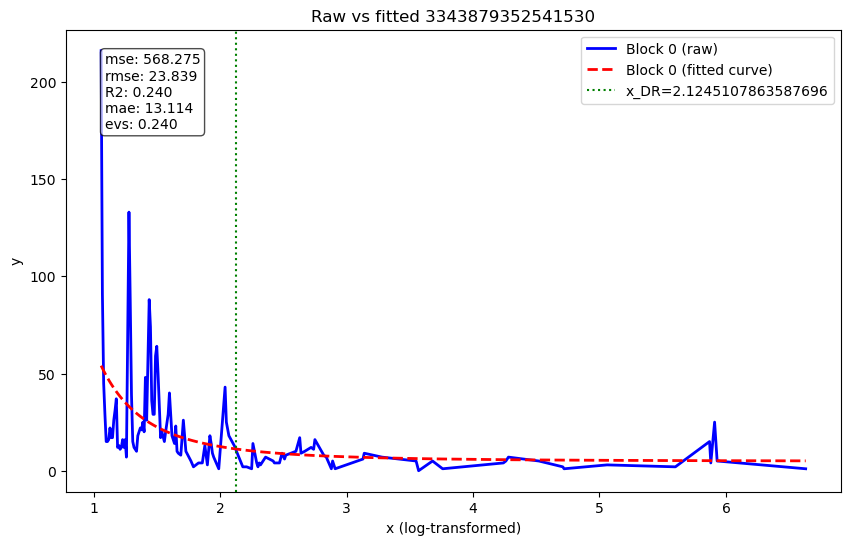

See below for more examples.

In [43]:

def Compute_Secant_DR(x_col,a,b,c,model='power'):
    """ Computes the point of diminishing return for our models."""
    if model=='power':
        x_0 = x_col.iloc[0]
        x_1 = x_col.iloc[-1]
        return (b*(x_1 - x_0)/(x_0**(-b) - x_1**(-b)))**(1/(b+1))
    elif model=='decay_exp':
        x_0 = x_col.iloc[0]
        x_1 = x_col.iloc[-1]
        return 1/b * np.log(b(x_1 - x_0)/(np.exp(-b*x_0) - np.exp(-b*x_1)))
    elif model == 'log':
        x_0 = x_col.iloc[0]
        x_1 = x_col.iloc[-1]
    else:
        raise ValueError('Model must be "power", "log", or "decay_exp"')

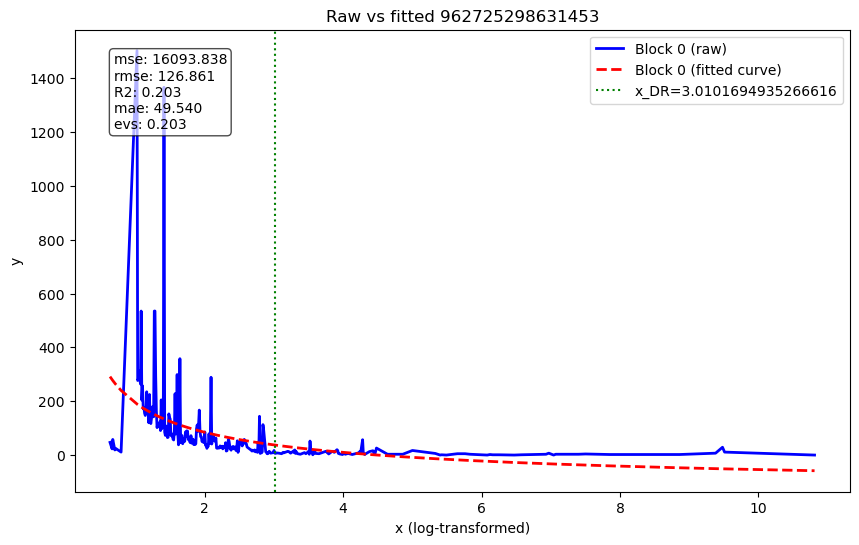

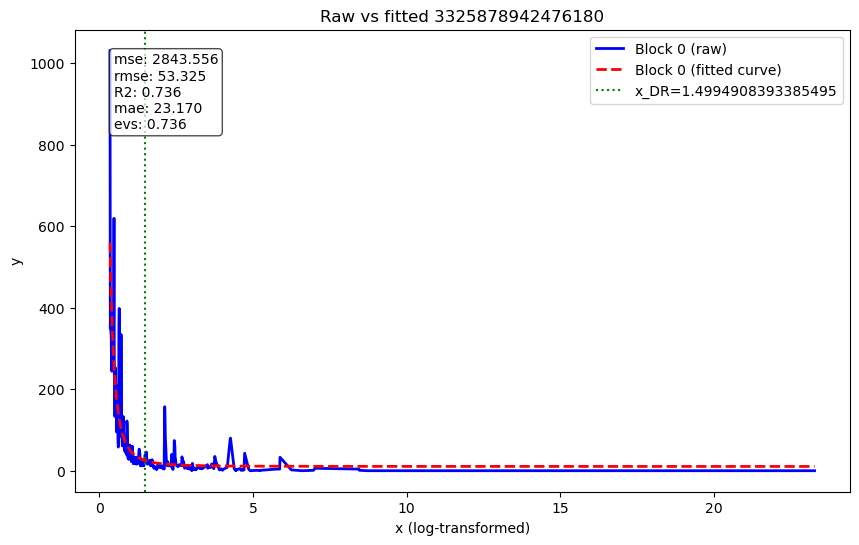

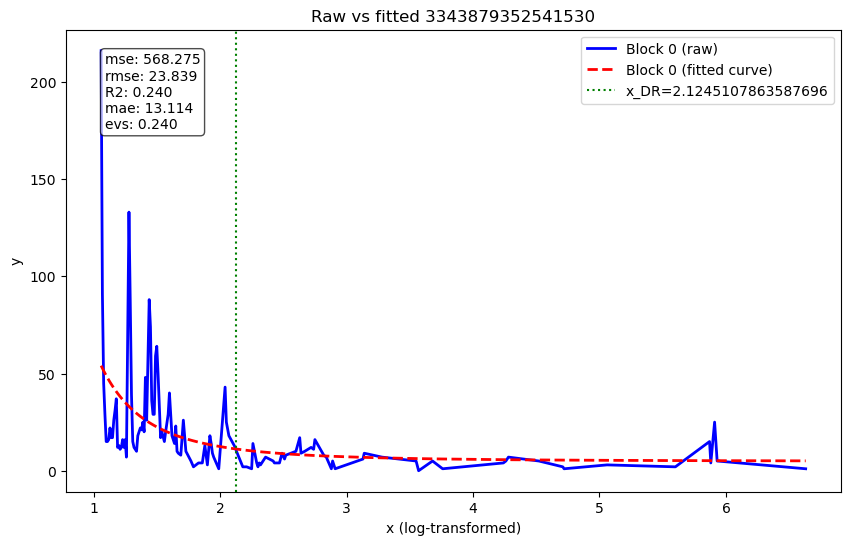

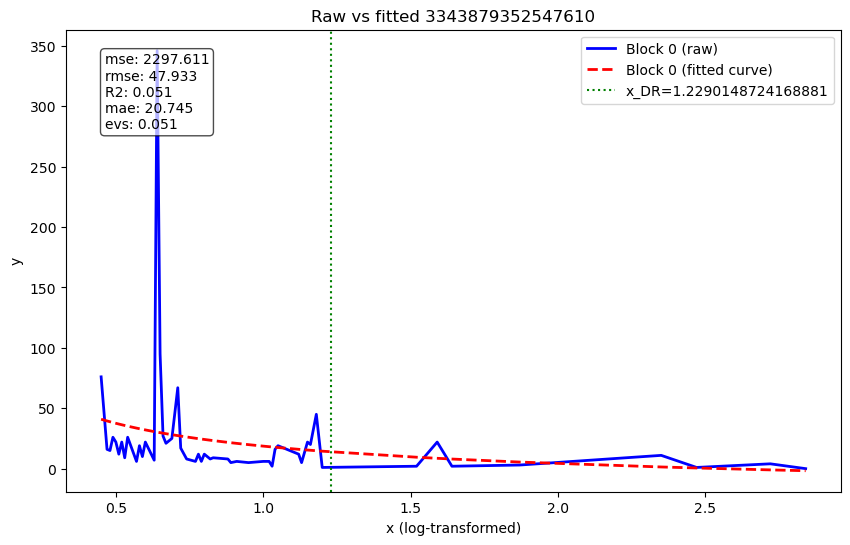

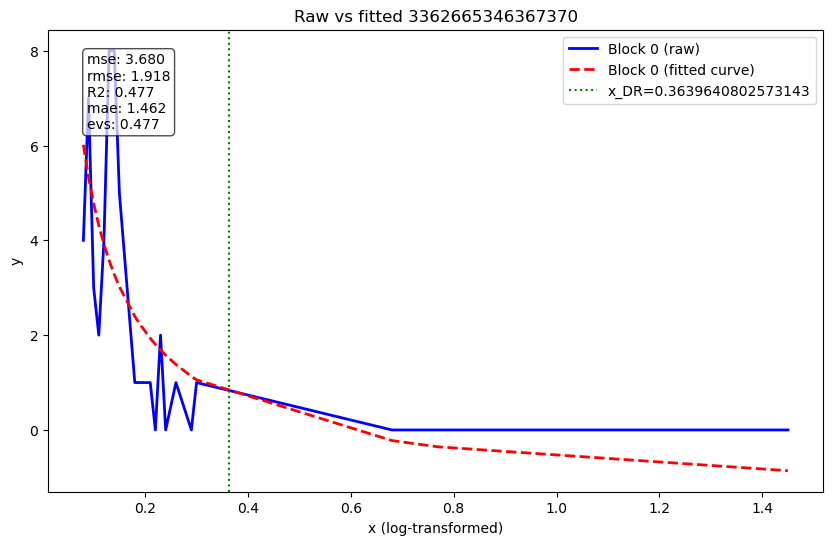

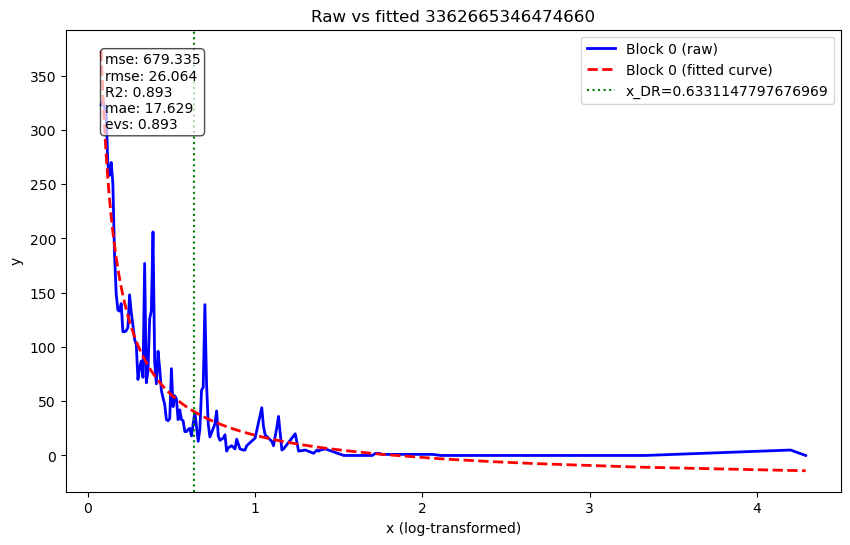

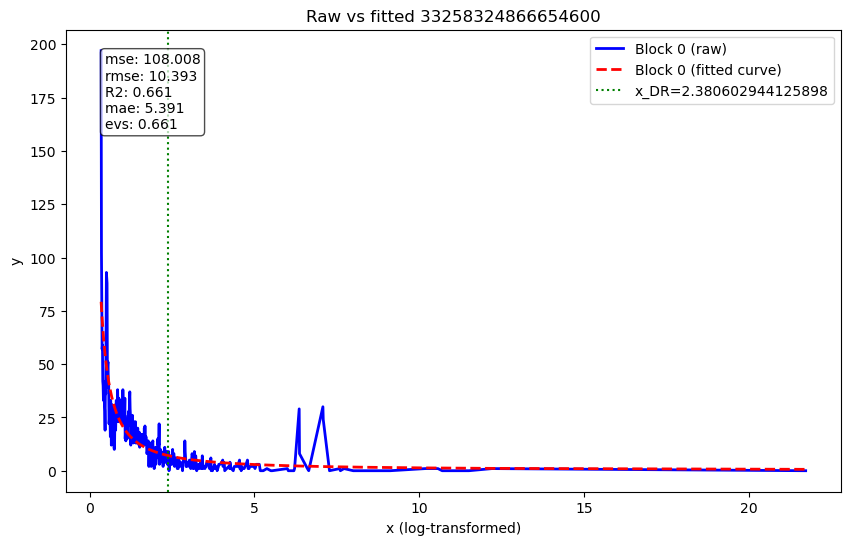

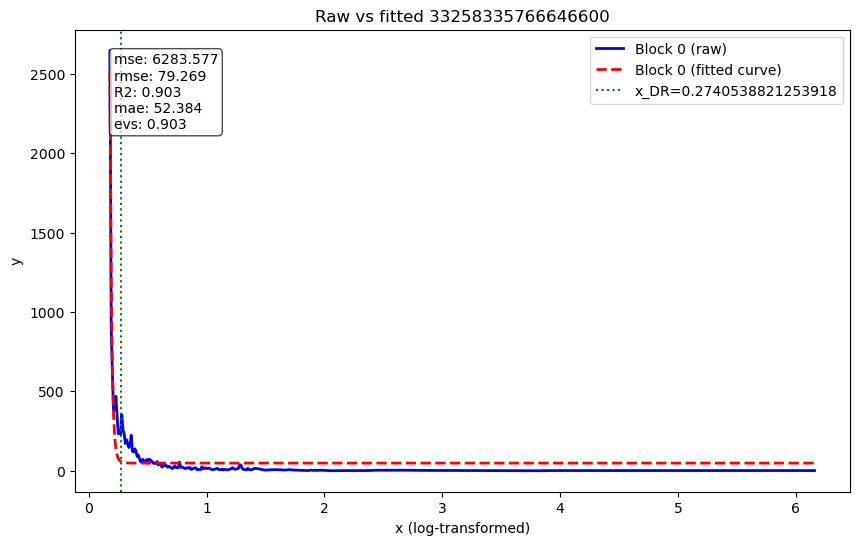

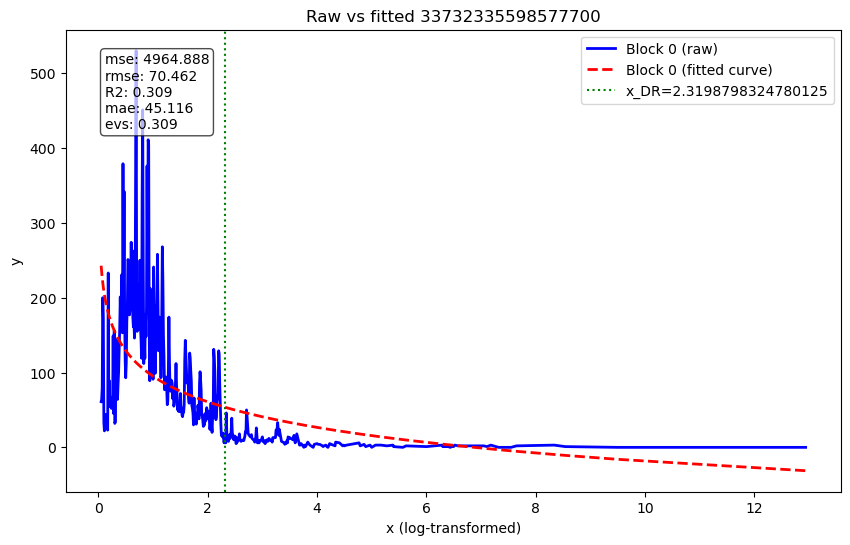

In [44]:
# Examples

examples = {
                3343879352541530: [0], 
                33258335766646600:[0],
                3325878942476180: [0],
                3362665346367370: [0],
                3325832486665400: [0],
                962725298631453: [0],
                3343879352547610: [0],
                33258324866654600: [0],
                3362665346474660:[0],
                33732335598577700:[0]

        }
df_ex = df_bl_filtered

keys = list(examples.keys())
df_subset = df_ex[df_ex['Key'].isin(keys)]

for k, group_key in df_subset.groupby("Key"):

        block_list = sorted(examples[k])

        for i, block in enumerate(block_list):
                plt.figure(figsize=(10, 6))
                group_block_sorted = group_key[group_key["block"] == block].sort_values("x")

                # compute fitted curve:
                success,metrics,fit_col,params = fit_curve(group_block_sorted["x"],group_block_sorted["y"],model='power')

                # Compute DR point
                sdr_pt = Compute_Secant_DR(group_block_sorted['x'],*params,model='power')

                plt.plot(group_block_sorted["x"], group_block_sorted["y"],
                        color='blue', linewidth=2, label=f"Block {block} (raw)")
                plt.plot(group_block_sorted["x"], fit_col,
                        color='red', linewidth=2,linestyle='--', label=f"Block {block} (fitted curve)")
                plt.axvline(x=sdr_pt,color='green',linestyle=':',label=f'x_DR={sdr_pt}')
                
                metrics_text = "\n".join([f"{k}: {v:.3f}" for k, v in metrics.items()])
                plt.text(0.05,0.95,metrics_text,transform=plt.gca().transAxes,verticalalignment='top',
                         bbox=dict(boxstyle='round',facecolor='white',alpha=0.7))

                plt.xlabel("x (log-transformed)")
                plt.ylabel("y")
                plt.title(f"Raw vs fitted {k}")
                plt.legend()
                plt.show()



In the last figure above, the data did not have a sufficiently good fit with our model. Even so, I believe it still provides a reasonable estimate of the diminishing return point for the fitted portion. As mentioned earlier, a more complex model could improve the fit, but this would require adjusting the definition of the diminishing return point. One question that arises is whether my current definition could be adapted for these scenarios, where multiple points of diminishing return exist. One possible approach is to select the maximum of these points, which could serve as a reliable and interpretable way to define the diminishing return.


In [45]:
# Summary function for fitting the curve and computing the DR

def evaluate_all_with_dr(dataframe, model='power',ss_req=10):
    results = []

    for (key, block), group in dataframe.groupby(['Key', 'block']):
        success, metrics, fit_col, params = fit_curve(group['x'],group['y'],model=model,ss_req=ss_req)
        if success:
            dr = Compute_Secant_DR(group['x'],*params,model=model)
        else:
            dr=None
        results.append({
            "key_col": key,
            'block_col': block,
            'success': success,
            'params':params, 
            'dr': dr
        } | metrics )

    results_df = pd.DataFrame(results)

    # summary

    total = len(results_df)
    success_counts = results_df['success'].sum()
    success_pct = 100*success_counts/total

    avg_metrics = {}
    for key in ['mse','rmse','R2','mae','evs']:
        avg_metrics['avg_'+key] = results_df[key].mean(skipna=True)
    

    summary = {
        'total_groups': total,
        'successful_fits': success_counts,
        'success_rate_pct':success_pct
    } | avg_metrics

    summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['value'])

    return summary_df, results_df

In [ ]:
# The following is the summary of fitting the models and finding the point of diminishing return
summary_dr, results_dr_df = evaluate_all_with_dr(df_bl,model='power')
display(results_dr_df)

,key_col,block_col,success,params,dr,mse,rmse,R2,mae,evs
0,82353292333796,0,True,"[229.66453177481682, 1.1506458938101078, -163....",0.304837,4.467677e+05,6.684069e+02,0.962221,2.170845e+02,0.962221
1,82353292333796,1,True,"[226.56093041547012, 3.79064273854176, 1.68689...",4.922573,1.243661e+01,3.526558e+00,0.588490,2.039549e+00,0.588490
2,82353292333796,2,True,"[1.5582468068443799e-25, 0.9999999859797811, 1...",15.510948,4.693324e-52,2.166408e-26,0.000000,1.983241e-26,0.000000
3,96272529898556,0,True,"[289.44276047406896, 1.1804940467790814, -75.8...",2.078544,2.398815e+04,1.548811e+02,0.446465,6.721863e+01,0.446465
4,96272529898556,1,True,"[28.24098887386777, 1.1352870336501513, -0.684...",8.580548,1.799944e+01,4.242574e+00,0.575084,2.030297e+00,0.575084
...,...,...,...,...,...,...,...,...,...,...
1007,35382347368695600,13,True,"[-4.136754585538063e-41, 1.000000008434712, 3....",1.129159,4.858813e-82,2.204272e-41,0.000000,1.736326e-41,0.000000
1008,35382347368695600,14,True,"[1.0170528651883092e-35, 1.000000054284357, -8...",7.386420,6.676173e-69,8.170785e-35,0.000000,8.168541e-35,0.000000
1009,37262356796747504,0,True,"[0.3300609813870688, 4.568510670960721, 10.827...",0.584977,1.307946e+03,3.616554e+01,0.728634,1.340240e+01,0.728634
1010,37262356796747504,1,True,"[27.39950831226151, 2.9862058123104265, 0.7082...",4.650677,9.172040e+00,3.028538e+00,0.233145,9.771260e-01,0.233145


## Conclusion

In this challenge, we analyzed a dataset consisting of (Key, block) pairs with variables **x** and **y** to study diminishing returns. Our approach involved fitting appropriate curves to each block and then estimating the diminishing return point based on the expected value of marginal returns.

### Key Findings
- The majority of curves exhibit a **decaying, concave-up relationship** between **x** and **y**.
- A few exceptions show bumps or concave-down regions, indicating that more complex models, such as $x^ne^{-\lambda x}$, would be needed for these cases.
- To ensure reliable curve fitting, we removed 94 groups with fewer than 10 observations, as small groups can produce unstable fits.

### Model Performance
- Among the models tested, the **power model** provided the best balance between fit quality and coverage, with slightly fewer successfully fitted groups than the decay exponential model, but lower average RMSE and higher R2.
- Metrics such as **MSE, RMSE, R2, and MAE** confirmed that the chosen model is able to capture the underlying trends for the majority of groups.

### Methodological Insights
- The procedure of first fitting the curve and then using the geometry of the fitted model to approximate the diminishing return point proved effective, as the point always falls within the observed interval of x-values.
- This approach connects the global expectations (average marginal return) with local observations (pointwise marginal return), providing an interpretable business measure.
- However, this depends on the general trend of the data. If the trend does not follow a concave-up function, the model fit is less reliable.
- I believe that if a more complex model were applied to the data, we could still use the same definition for the point of diminishing return. In this case, it could be defined as the last point where the marginal return equals the expected value of the marginal return, indicating the point beyond which marginal returns fall below the average and does not come back up. 

### Practical Implications
The diminishing return points can help inform decisions such as:

- **Optimal spend** – determining how much to invest in marketing campaigns to maximize revenue without overspending.  
- **Production quantity** – optimizing the number of products to produce to reduce per-unit costs, while avoiding excess inventory that could lead to losses.  
- **Bidding strategy** – setting a minimal bid for an ad spot on a webpage, balancing the likelihood of winning the ad with the decreasing number of bids as the price increases.


### Future Work
- For blocks that do not follow a simple concave-up pattern, more complex models could improve accuracy.
- Compare the current definition of the point of diminishing return with alternative definitions to evaluate strengths and weaknesses.  
  For example, if we let $\alpha \in (0,1)$ and $f$ be a concave-up function on the closed interval $[x_0,x_1]$, one could define the point of diminishing return $x_{DR}$ as:  
  $$
  x_{DR} = \min(x : |f'(x)| \leq \alpha |f'(x_0)|).
  $$  
  This method allows flexibility in choosing an "early" or "late" diminishing return, but it may not account for the full dataset and could produce a point outside the interval $[x_0,x_1]$.
- A generalized version of my definition could incorporate a scaling factor $\alpha \in (0,1]$, where  
  $$
  f'(x_{DR}) = \alpha \, \mathbb{E}[f'(X)].
  $$
- Another alternative is to define $x^*$ as the point where the curvature is maximum, identifying the "leg" of the curve where it bends most sharply. This could also be interpreted as the onset of diminishing returns. 
